<a href="https://colab.research.google.com/github/summerhasama/deeplearninga1/blob/main/SH_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [73]:
import matplotlib.pyplot as plot
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlretrieve
import numpy as np
from sklearn.model_selection import train_test_split
import random
import sys
import re, cgi

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [9]:
url_book_1 ="https://www.gutenberg.org/cache/epub/1342/pg1342.txt" # Pride and prejudice by Jane Austen
urlretrieve(url_book_1, 'book1.txt')
ptext = open("book1.txt", encoding='utf-8').read().lower()

url_book_2 ="https://www.gutenberg.org/cache/epub/64317/pg64317.txt" # Great Gatsby by F Scott Fitzgerald
urlretrieve(url_book_2, 'book2.txt')
gtext = open("book2.txt", encoding='utf-8').read().lower()

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [12]:
g_char_count= len(gtext)
p_char_count=len(ptext)
print('Num chars in the Great Gatsby by F Scott Fitzgerald:',g_char_count)
print('Num chars in Pride and Prejudice by Jane Austin:', p_char_count)

Num chars in the Great Gatsby by F Scott Fitzgerald: 289901
Num chars in Pride and Prejudice by Jane Austin: 748079


<BarContainer object of 2 artists>

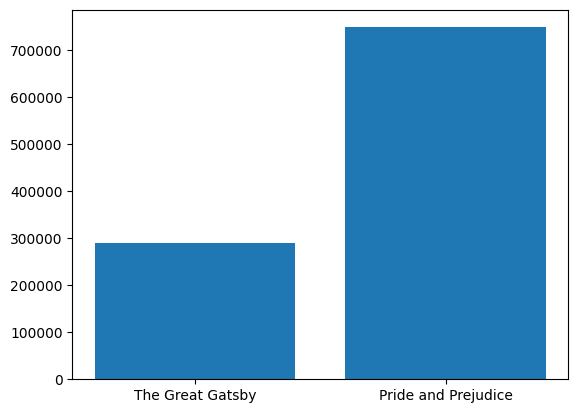

In [13]:
plot.bar(["The Great Gatsby", "Pride and Prejudice"], [g_char_count,p_char_count])

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [19]:
# Universal list of characters
chars = sorted(list(set(gtext+ptext)))

# character->index and index->character dictionaries for the one-hot encodings
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

g_seqs= []
p_seqs= []
seq_length=60
alphabet_length = len(chars)
for i in range(0, g_char_count,seq_length):
    g_seqs.append(gtext[i:i+seq_length])
for i in range(0, p_char_count, seq_length):
    p_seqs.append(ptext[i:i+seq_length])

In [75]:
batch = len(p_seqs+g_seqs)
X = np.zeros((batch, seq_length, alphabet_length), dtype =float)
y = np.zeros((batch,1), dtype=float)

In [76]:
# one hot encodings
for i, sentence in enumerate(p_seqs):
    for t, char in enumerate(sentence): 
        X[i,t,char_indices[char]] = 1
    y[i][0] = 1 # author is F Scott Fitzgerald

for i, sentence in enumerate(g_seqs):
    for t, char in enumerate(sentence): 
        X[i+len(p_seqs),t,char_indices[char]] = 1
    y[i+len(p_seqs)][0] = 0 # author is Jane Austen

## Data splitting
Split the data into train, validate and test sets. 

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [78]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, alphabet_length), dropout=0.2))
model.add(Dense(1, activation="sigmoid"))
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128)               105984    
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 106,113
Trainable params: 106,113
Non-trainable params: 0
_________________________________________________________________


## Model training
Train the model and apply early stopping.

In [79]:
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

model.fit(X_train, y_train, 
          epochs=20, batch_size=32,
          validation_data=(X_val,y_val),
          callbacks=[es],
          verbose=2)

Epoch 1/20
325/325 - 49s - loss: 0.6001 - accuracy: 0.7187 - val_loss: 0.5911 - val_accuracy: 0.7205 - 49s/epoch - 150ms/step
Epoch 2/20
325/325 - 36s - loss: 0.5998 - accuracy: 0.7199 - val_loss: 0.5866 - val_accuracy: 0.7217 - 36s/epoch - 112ms/step
Epoch 3/20
325/325 - 35s - loss: 0.5924 - accuracy: 0.7177 - val_loss: 0.5693 - val_accuracy: 0.7370 - 35s/epoch - 108ms/step
Epoch 4/20
325/325 - 35s - loss: 0.5851 - accuracy: 0.7224 - val_loss: 0.5995 - val_accuracy: 0.7240 - 35s/epoch - 109ms/step
Epoch 5/20
325/325 - 35s - loss: 0.5516 - accuracy: 0.7513 - val_loss: 0.5207 - val_accuracy: 0.7737 - 35s/epoch - 109ms/step
Epoch 6/20
325/325 - 37s - loss: 0.5078 - accuracy: 0.7705 - val_loss: 0.5005 - val_accuracy: 0.7540 - 37s/epoch - 113ms/step
Epoch 7/20
325/325 - 49s - loss: 0.4726 - accuracy: 0.7882 - val_loss: 0.4336 - val_accuracy: 0.8029 - 49s/epoch - 151ms/step
Epoch 8/20
325/325 - 47s - loss: 0.4454 - accuracy: 0.7939 - val_loss: 0.4199 - val_accuracy: 0.8069 - 47s/epoch - 144

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [80]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

109/109 [==============================] - 5s 45ms/step - loss: 0.2956 - accuracy: 0.8671
Test loss: 0.29555970430374146
Test accuracy: 0.8670520186424255


## Confusion matrix
Calculate and display the confusion matrix.

109/109 [==============================] - 4s 33ms/step


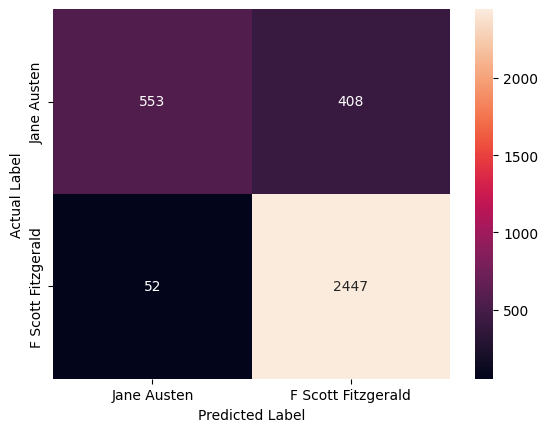

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model.predict(X_test) > 0.5
cm=confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Jane Austen", "F Scott Fitzgerald"], yticklabels=["Jane Austen", "F Scott Fitzgerald"])
plot.xlabel("Predicted Label")
plot.ylabel("Actual Label")
plot.show()